In [21]:
from pathlib import Path
import os
import shutil
import random
from tqdm import tqdm
import time
from glob import glob
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
import torchvision.models as models
import torch.nn.functional as F

In [22]:
data_dir = r"C:\Users\Saminathan\OneDrive\Desktop\Projects\SureScan\DATASET_classification"
data_dir = data_dir.replace('\\', '/')
dataset = datasets.ImageFolder(data_dir)

In [23]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [24]:
train, test = random_split(dataset, [train_size, val_size])

In [25]:
import torchvision.transforms as transforms

# Training Data Transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),   
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(15), 
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [27]:
class Brain44(torch.utils.data.Dataset):
    def __init__(self, subset, transform, class_names):
        self.subset = subset
        self.transform = transform
        self.class_names = class_names

    def __getitem__(self, index):
        img, label = self.subset[index]
        img_transformed = self.transform(img)
        return img_transformed, label

    def __len__(self):
        return len(self.subset)

    def plot_sample_images(self, num_images=5, cols=5):
        num_images = min(num_images, len(self.subset))
        img_indices = random.sample(range(len(self.subset)), num_images)

        cols = min(cols, num_images)
        rows = (num_images + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3))
        axes = axes.flatten()

        for i, idx in enumerate(img_indices):
            img, label = self.subset[idx]
            class_name = self.class_names[label]
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Label: \n{class_name}")

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.show()

    def plot_transformed_images(self, num_images=5):
        num_images = min(num_images, len(self.subset))
        img_indices = random.sample(range(len(self.subset)), num_images)

        for idx in img_indices:
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))

            img, label = self.subset[idx]
            transformed_img = self.transform(img)
            class_name = self.class_names[label]

            transformed_img = transformed_img.permute(1, 2, 0).numpy()

            axes[0].imshow(img)
            axes[0].axis("off")
            axes[0].set_title(f"Original ({class_name})")

            axes[1].imshow(transformed_img)
            axes[1].axis("off")
            axes[1].set_title(f"Transformed ({class_name})")

            plt.show()

In [28]:
class_names = dataset.classes

In [29]:
train_dataset = Brain44(train, train_transform, class_names)
test_dataset = Brain44(test, test_transform, class_names)

In [30]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
class_names = dataset.classes
class_to_idx = dataset.class_to_idx

print("Classes:", class_names)
print("len of Classes:", len(class_names))
print("Class-to-Index Mapping:", class_to_idx)
print("Train set size:", len(train_dataset))
print("test set size:", len(test_dataset))

Classes: ['Astrocitoma T1', 'Astrocitoma T1C+', 'Astrocitoma T2', 'Carcinoma T1', 'Carcinoma T1C+', 'Carcinoma T2', 'Ependimoma T1', 'Ependimoma T1C+', 'Ependimoma T2', 'Ganglioglioma T1', 'Ganglioglioma T1C+', 'Ganglioglioma T2', 'Germinoma T1', 'Germinoma T1C+', 'Germinoma T2', 'Glioblastoma T1', 'Glioblastoma T1C+', 'Glioblastoma T2', 'Granuloma T1', 'Granuloma T1C+', 'Granuloma T2', 'Meduloblastoma T1', 'Meduloblastoma T1C+', 'Meduloblastoma T2', 'Meningioma T1', 'Meningioma T1C+', 'Meningioma T2', 'Neurocitoma T1', 'Neurocitoma T1C+', 'Neurocitoma T2', 'Oligodendroglioma T1', 'Oligodendroglioma T1C+', 'Oligodendroglioma T2', 'Papiloma T1', 'Papiloma T1C+', 'Papiloma T2', 'Schwannoma T1', 'Schwannoma T1C+', 'Schwannoma T2', 'Tuberculoma T1', 'Tuberculoma T1C+', 'Tuberculoma T2', '_NORMAL T1', '_NORMAL T2']
len of Classes: 44
Class-to-Index Mapping: {'Astrocitoma T1': 0, 'Astrocitoma T1C+': 1, 'Astrocitoma T2': 2, 'Carcinoma T1': 3, 'Carcinoma T1C+': 4, 'Carcinoma T2': 5, 'Ependimom

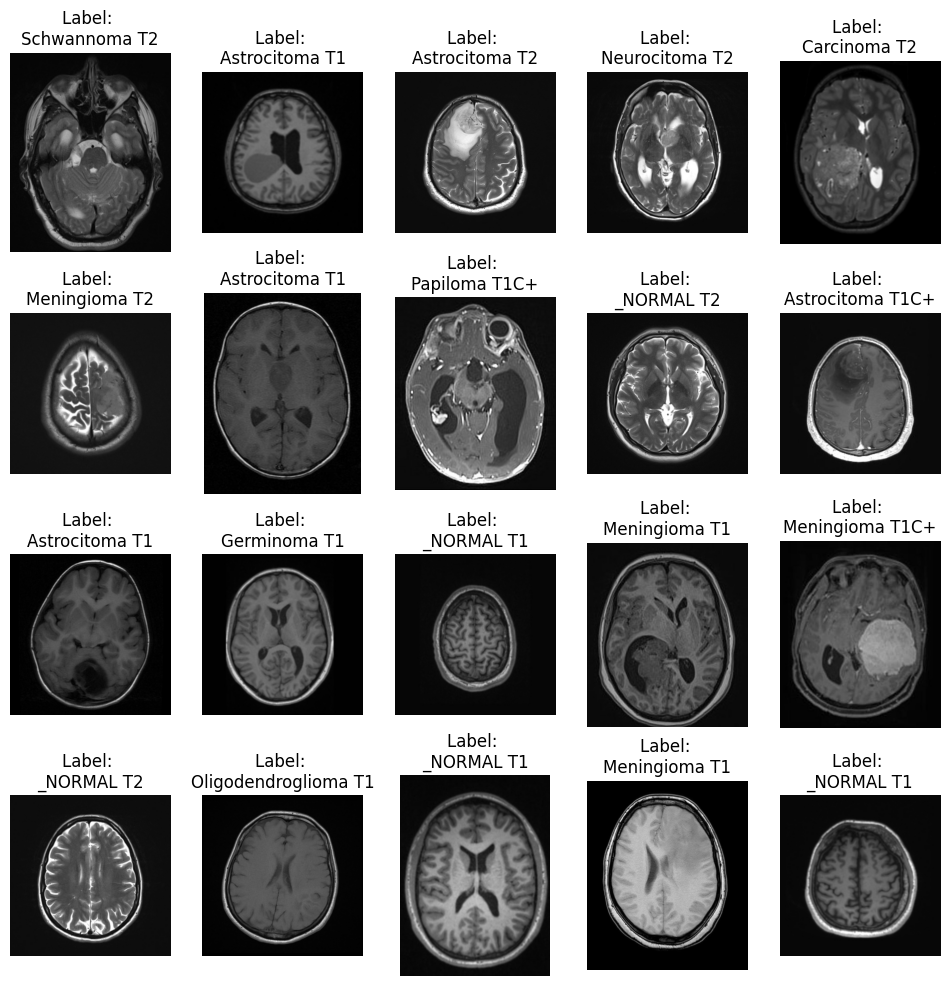

In [32]:
train_dataset.plot_sample_images(num_images=20)

In [34]:
class BrainTumorEfficientNet(nn.Module):
    def __init__(self, num_classes=44):
        super(BrainTumorEfficientNet, self).__init__()
        
        self.base_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.base_model.classifier = nn.Identity() 
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1536),
            nn.Linear(1536, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1) 
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x


num_classes = 44
model = BrainTumorEfficientNet(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adamax(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,080
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              SiLU-3         [-1, 40, 112, 112]               0
            Conv2d-4         [-1, 40, 112, 112]             360
       BatchNorm2d-5         [-1, 40, 112, 112]              80
              SiLU-6         [-1, 40, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 112, 112]               0
           Conv2d-13         [-1, 24, 112, 112]             960
      BatchNorm2d-14         [-1, 24, 1

In [35]:
def acc_fn(y_pred, y_true):
    return (y_pred == y_true).sum().item() / len(y_true)

In [36]:
def train_step(model, dataloader, loss_fn, acc_fn, optimizer, device):
  size = len(dataloader.dataset)
  batch_size = len(dataloader)
  model.train()
  train_loss, train_acc = 0, 0
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    acc = acc_fn(y_pred.argmax(dim=1), y)
    train_acc += acc

  return train_acc / batch_size, train_loss / batch_size

In [37]:
def test_step(model, dataloader, loss_fn, acc_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_acc = 0.0, 0.0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            acc = acc_fn(y_pred.argmax(dim=1), y)
            test_acc += acc

    return test_acc / num_batches, test_loss / num_batches

In [38]:
def trainx(model, train_dataloader, test_dataloader, loss_fn, acc_fn, optimizer, scheduler, device, epochs, save_path="brain_tumor_model.pth"):
    train_acc_list, test_acc_list = [], []
    train_loss_list, test_loss_list = [], []

    for epoch in range(epochs):
        train_acc, train_loss = train_step(model, train_dataloader, loss_fn, acc_fn, optimizer, device)
        test_acc, test_loss = test_step(model, test_dataloader, loss_fn, acc_fn, device)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(test_loss) 
        else:
            scheduler.step() 

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

        if (epoch + 1) % 4 == 0:
            model_filename = f"{save_path}_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), model_filename)
            print(f"Model saved at epoch {epoch+1}: {model_filename}")

    return train_acc_list, test_acc_list, train_loss_list, test_loss_list

In [39]:
epochs = 20
train_acc_list, test_acc_list, train_loss_list, test_loss_list= trainx(model, train_loader, test_loader, criterion, acc_fn, optimizer, scheduler, device, epochs)

Epoch 1: Train Acc: 0.3562, Train Loss: 2.5366 | Test Acc: 0.5871, Test Loss: 1.6041
Epoch 2: Train Acc: 0.6464, Train Loss: 1.3187 | Test Acc: 0.7121, Test Loss: 1.0476
Epoch 3: Train Acc: 0.7608, Train Loss: 0.8658 | Test Acc: 0.8025, Test Loss: 0.7113
Epoch 4: Train Acc: 0.8384, Train Loss: 0.5729 | Test Acc: 0.8393, Test Loss: 0.5720
Model saved at epoch 4: brain_tumor_model.pth_epoch4.pth
Epoch 5: Train Acc: 0.8906, Train Loss: 0.3881 | Test Acc: 0.8616, Test Loss: 0.4837
Epoch 6: Train Acc: 0.9244, Train Loss: 0.2737 | Test Acc: 0.8940, Test Loss: 0.3795
Epoch 7: Train Acc: 0.9456, Train Loss: 0.1954 | Test Acc: 0.9051, Test Loss: 0.3521
Epoch 8: Train Acc: 0.9542, Train Loss: 0.1632 | Test Acc: 0.9074, Test Loss: 0.3328
Model saved at epoch 8: brain_tumor_model.pth_epoch8.pth
Epoch 9: Train Acc: 0.9604, Train Loss: 0.1479 | Test Acc: 0.9141, Test Loss: 0.3051
Epoch 10: Train Acc: 0.9701, Train Loss: 0.1127 | Test Acc: 0.9163, Test Loss: 0.3042
Epoch 11: Train Acc: 0.9735, Train 

In [40]:
for param_group in optimizer.param_groups:
    print(f"Learning Rate: {param_group['lr']}")
    print(f"Weight Decay: {param_group.get('weight_decay', 0)}")

Learning Rate: 6.25e-05
Weight Decay: 0


In [41]:
def plot_metrics(train_acc, test_acc, train_loss, test_loss, epochs):
    fig, ax1 = plt.subplots(figsize=(8,5))

    # Left y-axis (Accuracy)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color='tab:blue')
    ax1.plot(range(1, epochs+1), train_acc, 'o-', label="Train Accuracy", color='tab:blue')
    ax1.plot(range(1, epochs+1), test_acc, 's-', label="Test Accuracy", color='tab:cyan')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Loss', color='tab:red')
    ax2.plot(range(1, epochs+1), train_loss, 'o--', label="Train Loss", color='tab:red')
    ax2.plot(range(1, epochs+1), test_loss, 's--', label="Test Loss", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.suptitle('Training & Testing Accuracy and Loss')
    fig.legend(loc="upper center", bbox_to_anchor=(0.7, 0.55), ncol=2)

    plt.show()

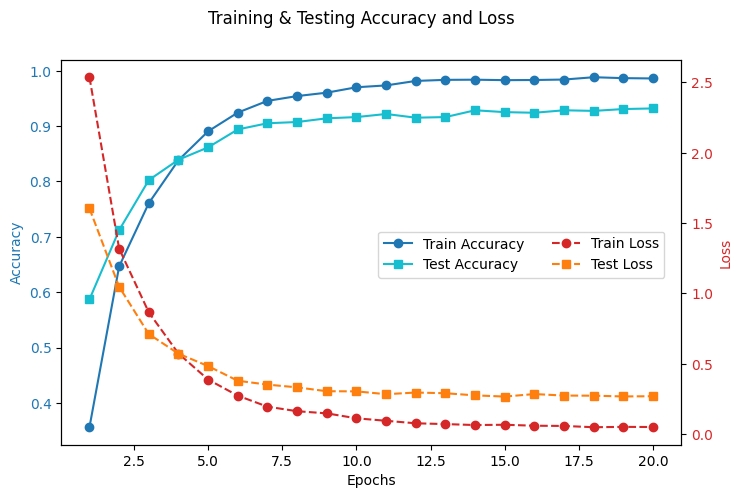

In [42]:
plot_metrics(train_acc_list, test_acc_list, train_loss_list, test_loss_list, epochs)